In [ ]:
# Required Packages
!pip install -qU bitsandbytes transformers datasets accelerate loralib einops xformers
!pip install -q -U git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.2/218.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 714.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

### Full Finetuning vs LoRA vs QLoRA

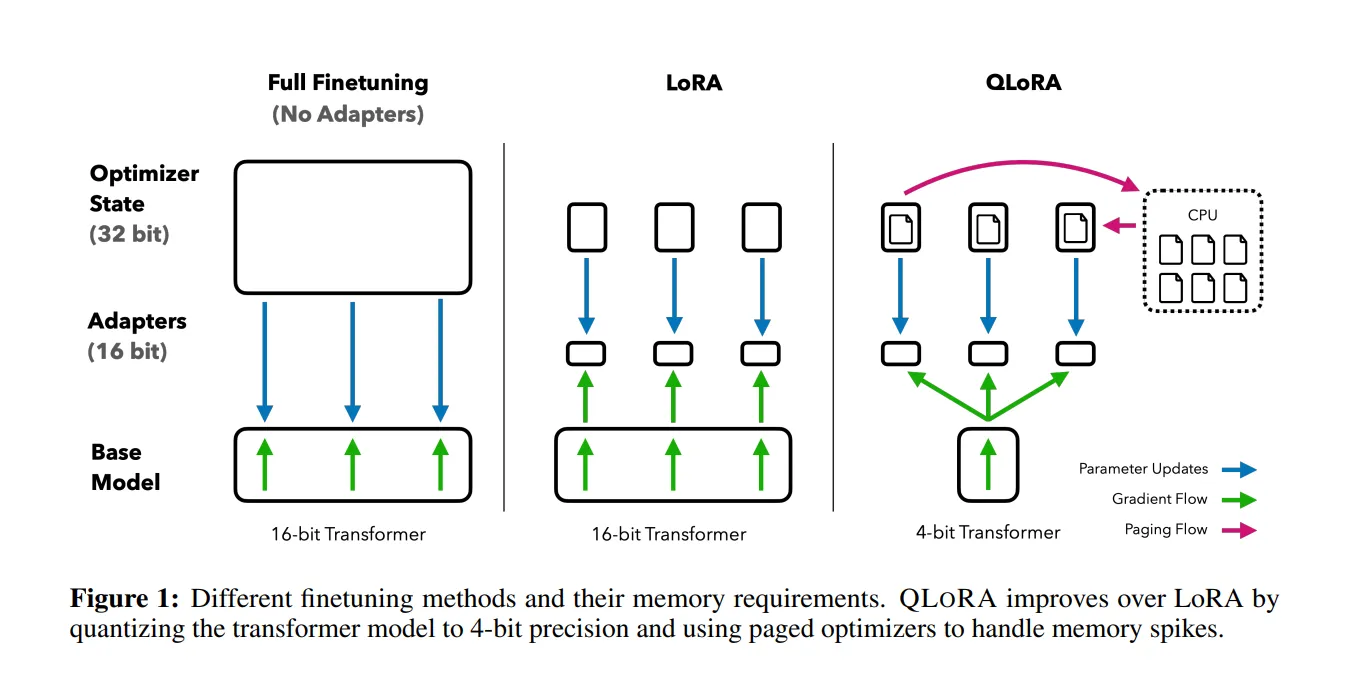

In [ ]:
# Imports
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

In [ ]:
# Base Model
model_id = "tiiuae/falcon-7b"

# Quantization Configuration
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  load_4bit_use_double_quant=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.bfloat16,
)

# Loading Base Model with Quantization Configuration
base_model=AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

# Load Tokenizer and setting Padding Token
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [ ]:
# Prepare the model for QLoRA Training
base_model = prepare_model_for_kbit_training(base_model)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [ ]:
# Configuring LoRA
lora_config = LoraConfig(
    r=16, # The rank of the update matrices, smaller rank will result in fewer trainable parameters.
    lora_alpha=32, # Scaling Factor
    target_modules=["query_key_value"], # Target module of the network, such as attention block
    lora_dropout=0.05, # Dropout probability
    bias="none", # If biases parameters should be trained
    task_type="CAUSAL_LM" # Task Type
)
# Getting the Peft Model
base_model = get_peft_model(base_model, lora_config)

In [ ]:
# Loading Dataset
dataset_name = 'Amod/mental_health_counseling_conversations'
dataset = load_dataset(dataset_name, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Custom Prompt generation for dataset
def build_prompt(data_point):
  return f"""
<user>: {data_point["Context"]}
<assistant>: {data_point["Response"]}
""".strip()

# Generate Prompt and Tokenize it
def build_and_tokenize(data_point):
  prompt = build_prompt(data_point)
  tokenized_prompt = tokenizer(prompt, padding=True, truncation=True)
  return tokenized_prompt

In [ ]:
# Shuffle dataset and tokenize it
dataset = dataset.shuffle().map(build_and_tokenize)

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [ ]:
# Configuring Training Argument
training_args = transformers.TrainingArguments(
  auto_find_batch_size=True,
  num_train_epochs=1,
  learning_rate=2e-4,
  # bf16=True,
  save_total_limit=4,
  logging_steps=1,
  output_dir='checkpoints',
  save_strategy='epoch',
)

In [ ]:
# Starting Training Loop
trainer = transformers.Trainer(
  model=base_model,
  train_dataset=dataset,
  args=training_args,
  data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
base_model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,2.554600


Step,Training Loss
1,2.731200
2,2.434000
3,2.223900
4,2.541500
5,2.331300
6,2.323300
7,2.304000
8,2.265300
9,2.281900
10,2.296700
